In [ ]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the CSV data
df = pd.read_csv('Transformed_BME_Results_UPDATED.csv')

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Load data
df = pd.read_csv('Transformed_BME_Results_UPDATED.csv')
metric = 'Recall'  # Change to other metrics as needed

# ================================================
# 1. Compare Models (SVM vs KNN vs RF) - PAIRED
# ================================================
# Pivot to paired format (grouped by Dataset Version, Size, Run)
model_pivot = df.pivot_table(
    index=['Dataset Version', 'Dataset Size', 'Run'],
    columns='Model',
    values=metric
).dropna()

# Extract paired data for each model comparison
pairs = [('SVM', 'KNN'), ('SVM', 'RF'), ('KNN', 'RF')]
model_results = []

for a, b in pairs:
    data_a = model_pivot[a]
    data_b = model_pivot[b]

    # Paired t-test
    t_stat, t_p = stats.ttest_rel(data_a, data_b)

    # Wilcoxon signed-rank test (paired)
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(data_a, data_b)

    # Cohen's d (paired)
    diff = data_a - data_b
    d = np.mean(diff) / np.std(diff, ddof=1)

    model_results.append({
        'Comparison': f'{a} vs {b}',
        't-test p': t_p,
        'Wilcoxon p': wilcoxon_p,
        'Cohen\'s d': d
    })

# Convert to DataFrame
model_results_df = pd.DataFrame(model_results)

# ====================================================
# 2. Compare Dataset Versions (Original vs SMOTE vs Spline) - PAIRED
# ====================================================
# Pivot to paired format (grouped by Model, Size, Run)
version_pivot = df.pivot_table(
    index=['Model', 'Dataset Size', 'Run'],
    columns='Dataset Version',
    values=metric
).dropna()

version_pairs = [('Original', 'SMOTE'), ('Original', 'Spline'), ('SMOTE', 'Spline')]
version_results = []

for a, b in version_pairs:
    data_a = version_pivot[a]
    data_b = version_pivot[b]

    t_stat, t_p = stats.ttest_rel(data_a, data_b)
    wilcoxon_stat, wilcoxon_p = stats.wilcoxon(data_a, data_b)
    diff = data_a - data_b
    d = np.mean(diff) / np.std(diff, ddof=1)

    version_results.append({
        'Comparison': f'{a} vs {b}',
        't-test p': t_p,
        'Wilcoxon p': wilcoxon_p,
        'Cohen\'s d': d
    })

version_results_df = pd.DataFrame(version_results)

# ================================================
# 3. Compare Dataset Sizes (L vs S) - PAIRED
# ================================================
# Pivot to paired format (grouped by Model, Dataset Version, Run)
size_pivot = df.pivot_table(
    index=['Model', 'Dataset Version', 'Run'],
    columns='Dataset Size',
    values=metric
).dropna()

data_L = size_pivot['L']
data_S = size_pivot['S']

# Paired tests
t_stat, t_p = stats.ttest_rel(data_L, data_S)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(data_L, data_S)
diff = data_L - data_S
d = np.mean(diff) / np.std(diff, ddof=1)

size_results_df = pd.DataFrame([{
    'Comparison': 'L vs S',
    't-test p': t_p,
    'Wilcoxon p': wilcoxon_p,
    'Cohen\'s d': d
}])

# ================================================
# Apply FDR Correction to All p-values
# ================================================
# Collect all p-values
all_p_values = (
    model_results_df[['t-test p', 'Wilcoxon p']].values.flatten().tolist() +
    version_results_df[['t-test p', 'Wilcoxon p']].values.flatten().tolist() +
    size_results_df[['t-test p', 'Wilcoxon p']].values.flatten().tolist()
)

# Benjamini-Hochberg FDR correction
_, corrected_p, _, _ = multipletests(all_p_values, method='fdr_bh')

# Map corrected p-values back to results
corrected_idx = 0

for df in [model_results_df, version_results_df, size_results_df]:
    for col in ['t-test p', 'Wilcoxon p']:
        df[f'Corrected {col}'] = corrected_p[corrected_idx:corrected_idx + len(df)]
        corrected_idx += len(df)

# ================================================
# Display Results
# ================================================
print("----- Model Comparisons -----")
print(model_results_df.round(15))

print("\n----- Dataset Version Comparisons -----")
print(version_results_df.round(15))

print("\n----- Dataset Size Comparison -----")
print(size_results_df.round(15))

----- Model Comparisons -----
   Comparison      t-test p    Wilcoxon p  Cohen's d  Corrected t-test p  \
0  SVM vs KNN  5.120600e-11  8.009374e-08   1.846230        7.168820e-10   
1   SVM vs RF  1.003987e-09  7.819179e-06   1.613762        3.737708e-07   
2   KNN vs RF  5.103362e-01  1.141767e-01   0.121692        7.027912e-09   

   Corrected Wilcoxon p  
0              0.000027  
1              0.595392  
2              0.145316  

----- Dataset Version Comparisons -----
           Comparison  t-test p  Wilcoxon p  Cohen's d  Corrected t-test p  \
0   Original vs SMOTE  0.089828    0.081399   0.320410            0.125759   
1  Original vs Spline  0.573125    0.871550   0.104051            0.125759   
2     SMOTE vs Spline  0.044154    0.037797  -0.384157            0.617212   

   Corrected Wilcoxon p  
0              0.871550  
1              0.077270  
2              0.075595  

----- Dataset Size Comparison -----
  Comparison  t-test p  Wilcoxon p  Cohen's d  Corrected t-test p 

In [ ]:
df_og = df[df['Dataset Version'] == 'Original']
df_smote = df[df['Dataset Version'] == 'SMOTE']
df_spline = df[df['Dataset Version'] == 'Spline']

KeyError: 'Dataset Version'

In [ ]:
values = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']
types = ['Original', 'SMOTE', 'Spline']


for n in range(0, len(values)):
  print(f"{df_spline[values[n]].mean():.4f} +/- {df_spline[values[n]].std():.4f}")

NameError: name 'df_spline' is not defined

In [ ]:
df_large = df[df['Dataset Size'] == 'L']
df_small = df[df['Dataset Size'] == 'S']

In [ ]:
for n in range(0, len(values)):
  print(f"{df_small[values[n]].mean():.4f} +/- {df_small[values[n]].std():.4f}")

0.4433 +/- 0.0723
0.4139 +/- 0.1198
0.6201 +/- 0.2187
0.3130 +/- 0.1733
0.4638 +/- 0.0937
0.4925 +/- 0.0562


In [ ]:
df_svm = df[df.index == 'SVM']
df_knn = df[df.index == 'KNN']
df_rf = df[df.index == 'RF']

In [ ]:
df_knn

,Comparison,t-test p,Wilcoxon p,Cohen's d,Corrected t-test p,Corrected Wilcoxon p


In [ ]:
values = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']
for n in range(0, len(values)):
  print(f"{df_rf[values[n]].mean():.4f} +/- {df_rf[values[n]].std():.4f}")

KeyError: 'Test Acc'

Comparing each specific model combination

In [ ]:
import pandas as pd
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests
import itertools

# Load data
df = pd.read_csv("Transformed_BME_Results_UPDATED.csv")

# Define metrics to analyze
metrics = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']

# Define dataset versions and sizes to group by
dataset_versions = ['Original', 'SMOTE', 'Spline']
dataset_sizes = ['L', 'S']

# Initialize a dictionary to store results
results = {}

# Loop through each metric
for metric in metrics:
    print(f"\n===== Analyzing Metric: {metric} =====")

    # Prepare data for Friedman test: group by dataset version and size (ignore model)
    groups = []
    group_labels = []

    for version in dataset_versions:
        for size in dataset_sizes:
            # Extract all values for this version-size combination (across all models)
            values = df[(df["Dataset Version"] == version) & (df["Dataset Size"] == size)][metric].values

            # Skip if no data exists for this combination
            if len(values) > 0:
                groups.append(values)
                group_labels.append(f"{version}-{size}")

    # Perform Friedman test if at least 3 groups exist
    if len(groups) >= 3:
        stat, p = friedmanchisquare(*groups)
        print(f"Friedman Test p-value: {p:.4f}")

        if p < 0.05:
            print("Significant differences detected. Performing post-hoc Wilcoxon tests...")

            # Perform pairwise Wilcoxon tests with Bonferroni correction
            wilcoxon_results = []
            pairs = list(itertools.combinations(range(len(groups)), 2))

            for i, j in pairs:
                group1 = groups[i]
                group2 = groups[j]

                # Skip if groups have identical values (Wilcoxon will fail)
                if all(x == y for x, y in zip(group1, group2)):
                    print(f"Skipping {group_labels[i]} vs {group_labels[j]} (identical values)")
                    continue

                try:
                    _, p_val = wilcoxon(group1, group2)
                    wilcoxon_results.append({
                        'Group 1': group_labels[i],
                        'Group 2': group_labels[j],
                        'p-value': p_val
                    })
                except ValueError as e:
                    print(f"Skipping {group_labels[i]} vs {group_labels[j]} due to error: {e}")

            # Apply Bonferroni correction if results exist
            if wilcoxon_results:
                p_values = [res['p-value'] for res in wilcoxon_results]
                reject, corrected_p, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

                # Print significant pairs
                for res, corr_p, rej in zip(wilcoxon_results, corrected_p, reject):
                    if rej:
                        print(f"Significant difference: {res['Group 1']} vs {res['Group 2']} (p={corr_p:.4f})")
            else:
                print("No valid pairs for post-hoc testing.")
        else:
            print("No significant differences detected.")
    else:
        print("Insufficient groups for Friedman test.")


===== Analyzing Metric: Test Acc =====
Friedman Test p-value: 0.0000
Significant differences detected. Performing post-hoc Wilcoxon tests...
Significant difference: Original-L vs Original-S (p=0.0411)
Significant difference: Original-L vs SMOTE-L (p=0.0009)
Significant difference: Original-L vs SMOTE-S (p=0.0262)
Significant difference: Original-L vs Spline-L (p=0.0140)
Significant difference: Original-S vs Spline-S (p=0.0479)

===== Analyzing Metric: Precision =====
Friedman Test p-value: 0.0000
Significant differences detected. Performing post-hoc Wilcoxon tests...
Significant difference: Original-L vs Original-S (p=0.0219)
Significant difference: Original-L vs SMOTE-L (p=0.0009)
Significant difference: Original-L vs SMOTE-S (p=0.0046)
Significant difference: Original-L vs Spline-L (p=0.0141)
Significant difference: SMOTE-S vs Spline-S (p=0.0174)

===== Analyzing Metric: Recall =====
Friedman Test p-value: 0.0006
Significant differences detected. Performing post-hoc Wilcoxon tests..

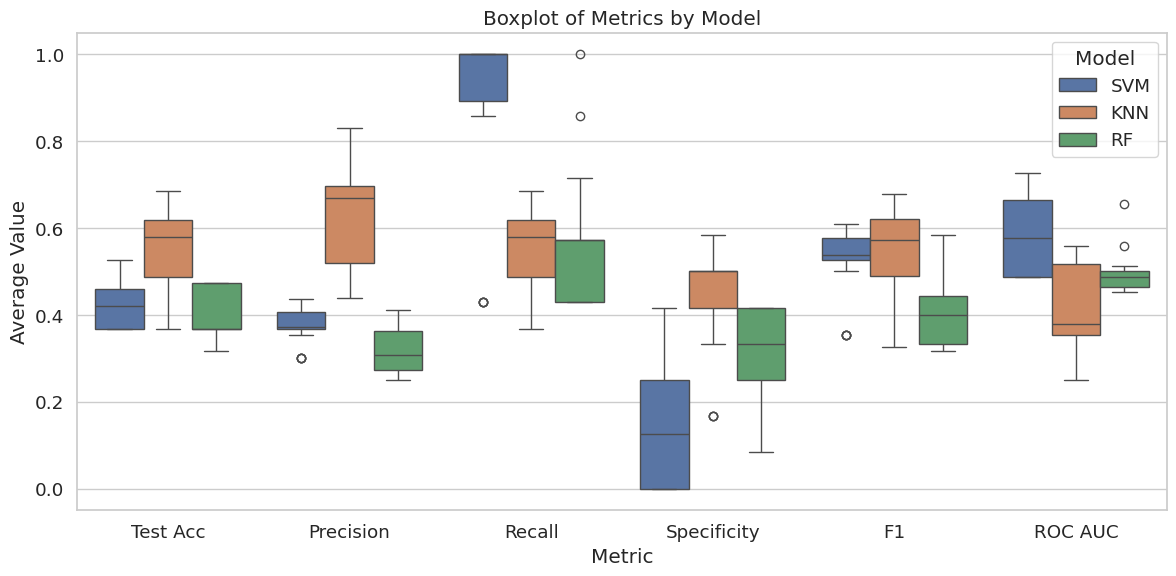

In [ ]:
# Load the CSV file
df = pd.read_csv('Transformed_BME_Results_UPDATED.csv')

# Select only the relevant columns
metrics = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']
df_melted = df.melt(id_vars=['Model'], value_vars=metrics,
                    var_name='Metric', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Metric', y='Value', hue='Model')
plt.title('Boxplot of Metrics by Model')
plt.ylabel('Average Value')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

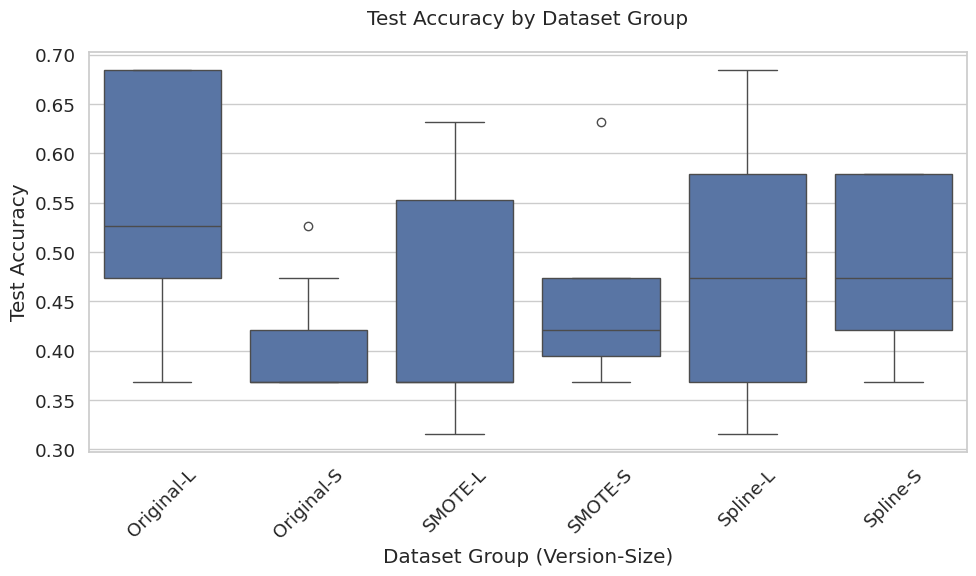

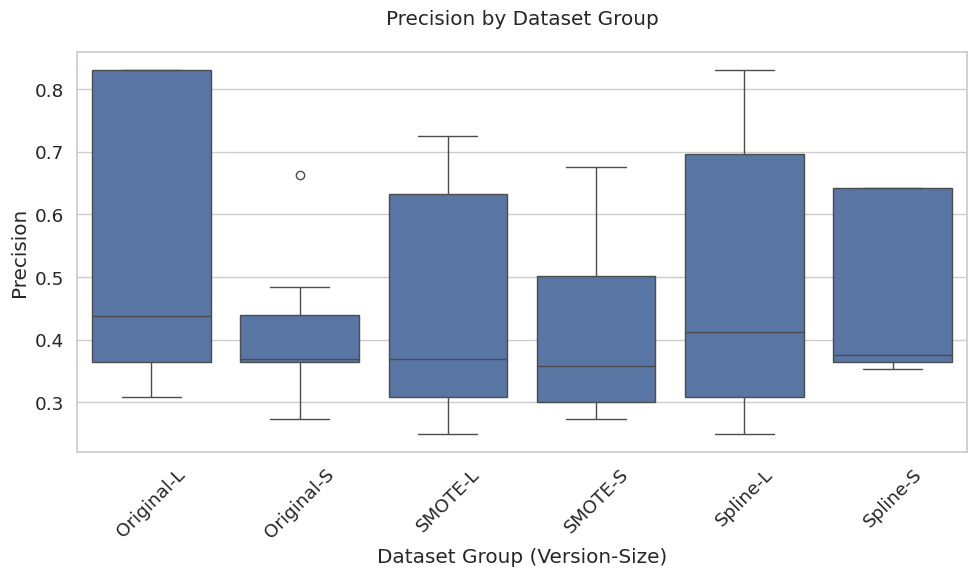

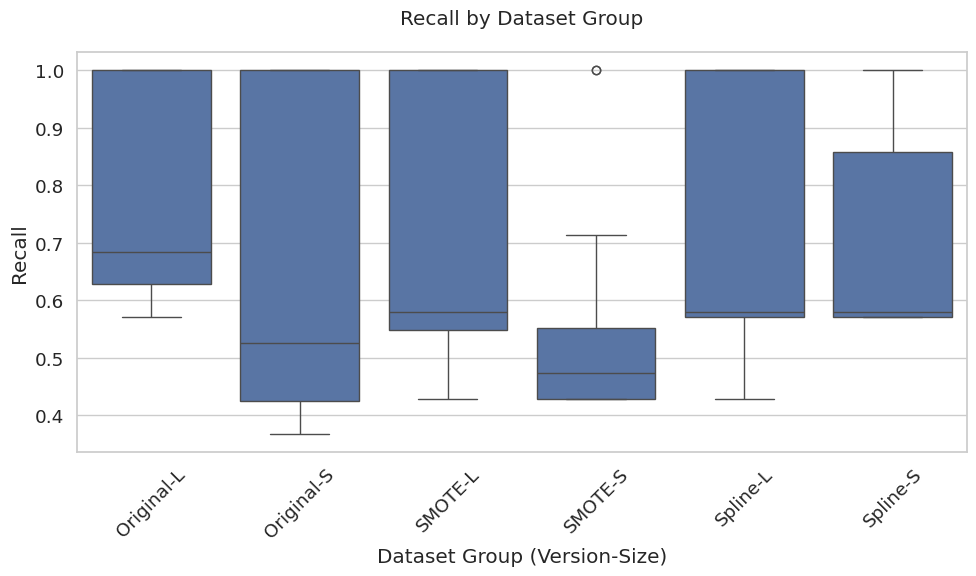

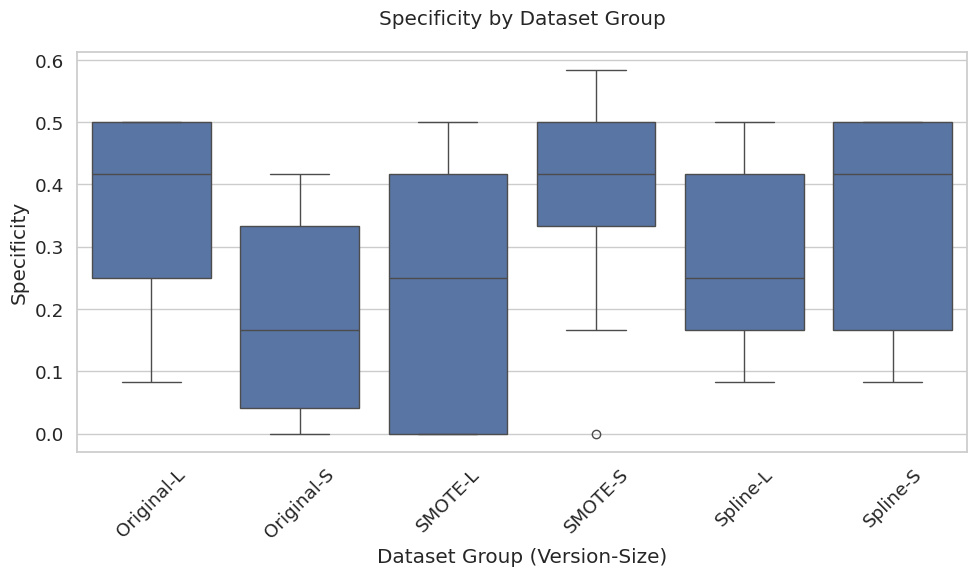

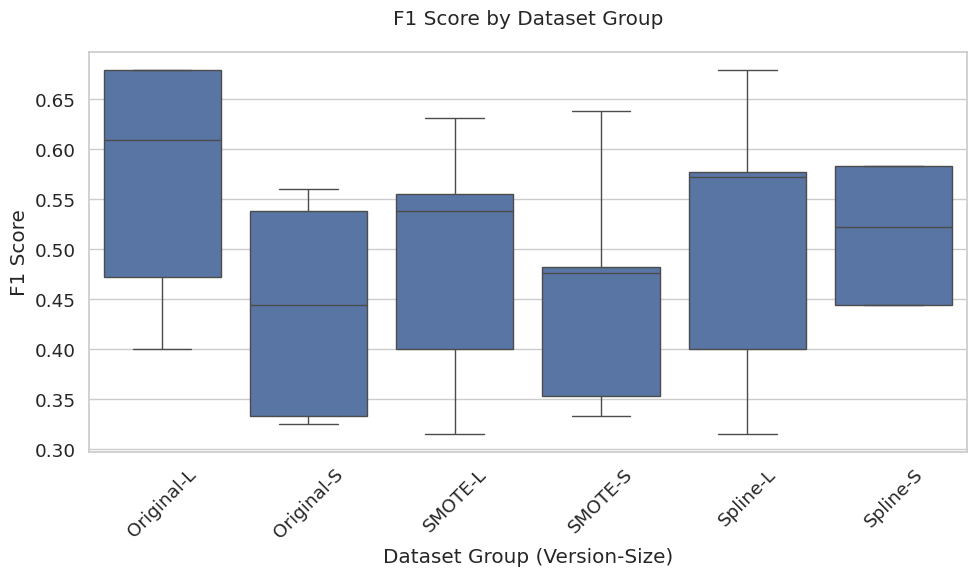

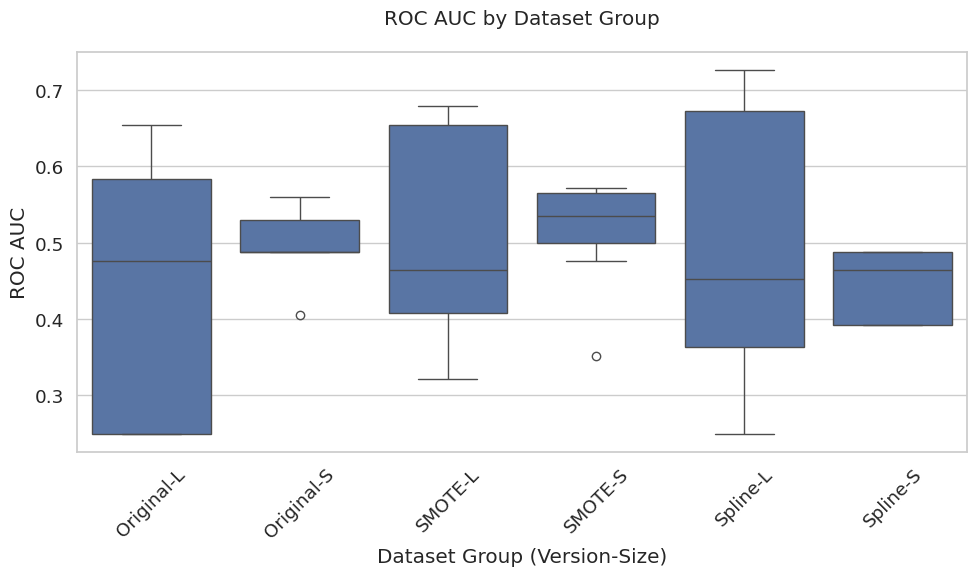

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Combine 'Dataset Version' and 'Dataset Size' into a new column for grouping
df['Group'] = df['Dataset Version'] + '-' + df['Dataset Size']

# Define metrics and their display names
metrics = {
    'Test Acc': 'Test Accuracy',
    'Precision': 'Precision',
    'Recall': 'Recall',
    'Specificity': 'Specificity',
    'F1': 'F1 Score',
    'ROC AUC': 'ROC AUC'
}

# Set style
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(18, 12))

for metric, display_name in metrics.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Group', y=metric, order=[
        'Original-L', 'Original-S',
        'SMOTE-L', 'SMOTE-S',
        'Spline-L', 'Spline-S'
    ])
    plt.title(f'{display_name} by Dataset Group', pad=20)
    plt.xlabel('Dataset Group (Version-Size)')
    plt.ylabel(display_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install scikit-posthocs

Tukey HSD Test

In [ ]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the data
df_2 = pd.read_csv('Transformed_BME_Results_UPDATED.csv')

# List of metrics to analyze
metrics_2 = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']

for metric in metrics_2:
    print(f"\n==================== {metric} ====================")

    # Filter relevant data and drop NaNs
    model_data = df_2[['Model', metric]].dropna()

    # Check how many observations per model
    group_counts = model_data.groupby('Model').size()
    print("Observations per model:\n", group_counts)

    # If any model has fewer than 2 observations, skip the test
    if group_counts.min() < 2:
        print("⚠️ Not enough observations per group to run Tukey HSD. Skipping.")
        continue

    # Run one-way ANOVA first
    model = ols(f'Q("{metric}") ~ C(Model)', data=model_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nOne-way ANOVA Results:")
    print(anova_table)

    p_value = anova_table["PR(>F)"][0]

    # Only run Tukey if ANOVA is significant
    if p_value < 0.05:
        print("\n✅ Significant ANOVA result (p < 0.05). Proceeding with Tukey HSD...")

        # Run Tukey HSD
        tukey_model = pairwise_tukeyhsd(endog=model_data[metric], groups=model_data['Model'], alpha=0.05)
        print("\nTukey HSD - Model Comparisons")
        print(tukey_model.summary())

        # Access and print detailed results with more decimal places
        print("\nDetailed Results with More Decimal Places:")
        headers = tukey_model._results_table.data[0]
        data_rows = tukey_model._results_table.data[1:]
        df_results = pd.DataFrame(data_rows, columns=headers)
        df_results['p-adj'] = df_results['p-adj'].astype(float).round(8)
        print(df_results)
    else:
        print("❌ ANOVA not significant (p >= 0.05). Tukey HSD test skipped.")



==================== Test Acc ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df          F        PR(>F)
C(Model)  0.443398   2.0  40.474133  3.749318e-13
Residual  0.476547  87.0        NaN           NaN

✅ Significant ANOVA result (p < 0.05). Proceeding with Tukey HSD...


<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.1596    0.0 -0.2052 -0.1141   True
   KNN    SVM  -0.1351    0.0 -0.1807 -0.0895   True
    RF    SVM   0.0246 0.4072  -0.021  0.0701  False
----------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.1596  0.0000 -0.2052 -0.1141    True
1    KNN    SVM   -0.1351  0.0000 -0.1807 -0.0895    True
2     RF    SVM    0.0246  0.4072 -0.0210  0.0701   False

==================== Precision ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df           F        PR(>F)
C(Model)  1.898609   2.0  139.727028  6.827124e-28
Residual  0.591077  87.0         NaN           NaN

✅ Significant ANO

<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.3346    0.0 -0.3854 -0.2839   True
   KNN    SVM   -0.272    0.0 -0.3227 -0.2212   True
    RF    SVM   0.0627 0.0114  0.0119  0.1134   True
----------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.3346  0.0000 -0.3854 -0.2839    True
1    KNN    SVM   -0.2720  0.0000 -0.3227 -0.2212    True
2     RF    SVM    0.0627  0.0114  0.0119  0.1134    True

==================== Recall ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df          F        PR(>F)
C(Model)  2.503599   2.0  57.611094  1.162879e-16
Residual  1.890374  87.0        NaN           NaN

✅ Significant ANOVA res

<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNN     RF  -0.0168 0.8984 -0.1075  0.074  False
   KNN    SVM   0.3451    0.0  0.2544 0.4359   True
    RF    SVM   0.3619    0.0  0.2712 0.4527   True
---------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.0168  0.8984 -0.1075  0.0740   False
1    KNN    SVM    0.3451  0.0000  0.2544  0.4359    True
2     RF    SVM    0.3619  0.0000  0.2712  0.4527    True

==================== Specificity ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df          F        PR(>F)
C(Model)  1.312963   2.0  49.385909  4.660848e-15
Residual  1.156481  87.0        NaN           NaN

✅ Significant ANOVA resul

<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.1222 0.0003 -0.1932 -0.0512   True
   KNN    SVM  -0.2944    0.0 -0.3654 -0.2235   True
    RF    SVM  -0.1722    0.0 -0.2432 -0.1012   True
----------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.1222  0.0003 -0.1932 -0.0512    True
1    KNN    SVM   -0.2944  0.0000 -0.3654 -0.2235    True
2     RF    SVM   -0.1722  0.0000 -0.2432 -0.1012    True

==================== F1 ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df          F        PR(>F)
C(Model)  0.428924   2.0  30.241012  1.068900e-10
Residual  0.616983  87.0        NaN           NaN

✅ Significant ANOVA result 

<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.1572    0.0 -0.2091 -0.1054   True
   KNN    SVM  -0.0246 0.4962 -0.0765  0.0272  False
    RF    SVM   0.1326    0.0  0.0807  0.1844   True
----------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.1572  0.0000 -0.2091 -0.1054    True
1    KNN    SVM   -0.0246  0.4962 -0.0765  0.0272   False
2     RF    SVM    0.1326  0.0000  0.0807  0.1844    True

==================== ROC AUC ====================
Observations per model:
 Model
KNN    30
RF     30
SVM    30
dtype: int64

One-way ANOVA Results:
            sum_sq    df          F        PR(>F)
C(Model)  0.517460   2.0  39.236937  7.150839e-13
Residual  0.573682  87.0        NaN           NaN

✅ Significant ANOVA re

<ipython-input-15-e5bbb4c72e87>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]



Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   KNN     RF   0.0905 0.0001 0.0405 0.1405   True
   KNN    SVM   0.1857    0.0 0.1357 0.2357   True
    RF    SVM   0.0952 0.0001 0.0452 0.1452   True
--------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF    0.0905  0.0001  0.0405  0.1405    True
1    KNN    SVM    0.1857  0.0000  0.1357  0.2357    True
2     RF    SVM    0.0952  0.0001  0.0452  0.1452    True


old tukey test

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the data if not already loaded
df_2 = pd.read_csv('Transformed_BME_Results_UPDATED.csv')

# List of metrics to analyze
metrics_2 = ['Test Acc', 'Precision', 'Recall', 'Specificity', 'F1', 'ROC AUC']

for metric in metrics_2:
  print(f"\n==================== {metric} ====================")
  # Filter for only necessary columns
  model_data = df_2[['Model', metric]].dropna()

  # Run Tukey HSD
  tukey_model = pairwise_tukeyhsd(endog=model_data[metric], groups=model_data['Model'], alpha=0.05)

  # Print the summary
  print("Tukey HSD - Model Comparisons")
  print(tukey_model.summary())

  # Access and print detailed results with more decimal places
  print("\nDetailed Results with More Decimal Places:")
  # Convert SimpleTable to DataFrame
  headers = tukey_model._results_table.data[0]  # First row contains headers
  data_rows = tukey_model._results_table.data[1:]  # Remaining rows contain data

  # Create a pandas DataFrame
  df_results = pd.DataFrame(data_rows, columns=headers)

  # Round the 'p-adj' column to 8 decimal places
  df_results['p-adj'] = df_results['p-adj'].astype(float).round(8)

  # Display the updated DataFrame
  print(df_results)



==================== Test Acc ====================
Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.1596    0.0 -0.2052 -0.1141   True
   KNN    SVM  -0.1351    0.0 -0.1807 -0.0895   True
    RF    SVM   0.0246 0.4072  -0.021  0.0701  False
----------------------------------------------------

Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF   -0.1596  0.0000 -0.2052 -0.1141    True
1    KNN    SVM   -0.1351  0.0000 -0.1807 -0.0895    True
2     RF    SVM    0.0246  0.4072 -0.0210  0.0701   False

==================== Precision ====================
Tukey HSD - Model Comparisons
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN     RF  -0.3346    0.0

In [ ]:
df_results

,group1,group2,meandiff,p-adj,lower,upper,reject
0,KNN,RF,0.0905,0.0001,0.0405,0.1405,True
1,KNN,SVM,0.1857,0.0000,0.1357,0.2357,True
2,RF,SVM,0.0952,0.0001,0.0452,0.1452,True


In [ ]:
import pandas as pd



Detailed Results with More Decimal Places:
  group1 group2  meandiff   p-adj   lower   upper  reject
0    KNN     RF    0.0905  0.0001  0.0405  0.1405    True
1    KNN    SVM    0.1857  0.0000  0.1357  0.2357    True
2     RF    SVM    0.0952  0.0001  0.0452  0.1452    True


In [ ]:
for metric in metrics_2:
  print(f"\n==================== {metric} ====================")
  # Filter for only necessary columns
  version_data = df_2[['Dataset Version', metric]].dropna()

  # Run Tukey HSD
  tukey_version = pairwise_tukeyhsd(endog=version_data[metric], groups=version_data['Dataset Version'], alpha=0.05)

  # Print the summary
  print("Tukey HSD - Dataset Version Comparisons")
  print(tukey_version.summary())


==================== Test Acc ====================
Tukey HSD - Dataset Version Comparisons
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Original  SMOTE  -0.0421 0.2438 -0.1042   0.02  False
Original Spline      0.0    1.0 -0.0621 0.0621  False
   SMOTE Spline   0.0421 0.2438   -0.02 0.1042  False
-----------------------------------------------------

==================== Precision ====================
Tukey HSD - Dataset Version Comparisons
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Original  SMOTE  -0.0519 0.4555  -0.155 0.0511  False
Original Spline  -0.0034 0.9966 -0.1065 0.0997  False
   SMOTE Spline   0.0485 0.5028 -0.0545 0.1516  False
-----------------------------------------------------

==================== Recall ====================
Tukey HSD